# Heat Loss from Temperature Measurements

In [84]:
import os
print(f'Current working dir:\t {os.getcwd()}')
from pathlib import Path

from datetime import datetime
# from datetime import timedelta

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import DataLoader, TensorDataset
import gpytorch
import math

from statsmodels_collection.gp_exact_rxpl import SingletaskExactGPpl
from statsmodels_collection.fitting import fit


%matplotlib widget

Current working dir:	 c:\GitRepos\various-data-analysis\heat-loss


<AxesSubplot:xlabel='timestamp'>

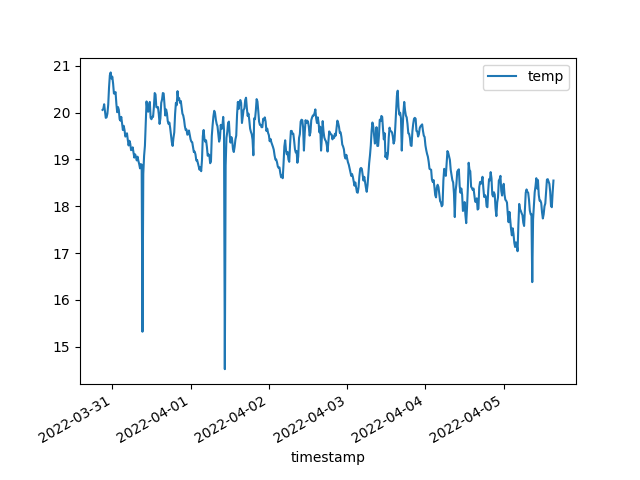

In [85]:
filename_temp_outside = Path("venkovni_teplota_2022-3-30T1800_2022-04-05T1000.csv")
filename_temp_inside = Path("vnitrni_teplota_2022-03-30T2100_2022-04-05T1515.csv")
root_data = Path("C:/DATA_FAST/temperature")
# read only header first for prep on parsing and stuff
# cols_from_header = pd.read_csv(root_data / filename_temp_out, nrows=0).columns.tolist()
data_temp_outside = pd.read_csv(root_data / filename_temp_outside, parse_dates=['timestamp'], index_col='timestamp') #.drop(columns=['payment_id'])
data_temp_inside = pd.read_csv(root_data / filename_temp_inside, parse_dates=['timestamp'], dayfirst=True, index_col='timestamp') #.drop(columns=['payment_id'])

data_temp_inside.plot()


## Data Shaping for GP Interpolation

In [86]:
def to_anchored_total_hours(anchor, time)->torch.Tensor:
    time_anchor = data_temp_outside.index[0]
    return torch.tensor((time - time_anchor).total_seconds()/3600., dtype=torch.float)

In [87]:
temp_outside_tens = torch.tensor(data_temp_outside.temp.to_numpy(), dtype=torch.float)
temp_inside_tens = torch.tensor(data_temp_inside.temp.to_numpy(), dtype=torch.float)
time_anchor = data_temp_outside.index[0]
time_outside = to_anchored_total_hours(time_anchor, data_temp_outside.index)
time_inside = to_anchored_total_hours(time_anchor, data_temp_inside.index)
 

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.scatter(data_temp_outside.index, temp_outside_tens)
ax.set_xlabel('Time')
ax.set_ylabel('Deg C')
ax.set_title('Temperature Outside')
fig.tight_layout()

model = SingletaskExactGPpl(
    temp_outside_tens,
    time_outside
)

loader = DataLoader(
    TensorDataset(
        time_outside,
        temp_outside_tens
    ),
    batch_size=1000,
    shuffle=False
)
# model.train()
fit(model,
    train_dataloader=loader,
    max_epochs=10000,
    patience=50,
    verbose=False)


c:\GitRepos\various-data-analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=True)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=True)`.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type                       | Params
----------------------------------------------------
0 | gp   | SingletaskExactGP          | 8     
1 | mll  | ExactMarginalLogLikelihood | 8     
----------------------------------------------------
8         Trainable params
0         Non-trainable params
8         Total params
0.000     Total estimated model params size (MB)
c:\GitRepos\various-data-analysis\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The d

Epoch 6452: 100%|██████████| 1/1 [02:06<00:00, 126.68s/it, loss=3.09, v_num=40, train_loss=3.090]

In [ ]:
# Make predictions
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model.predict(time_inside)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

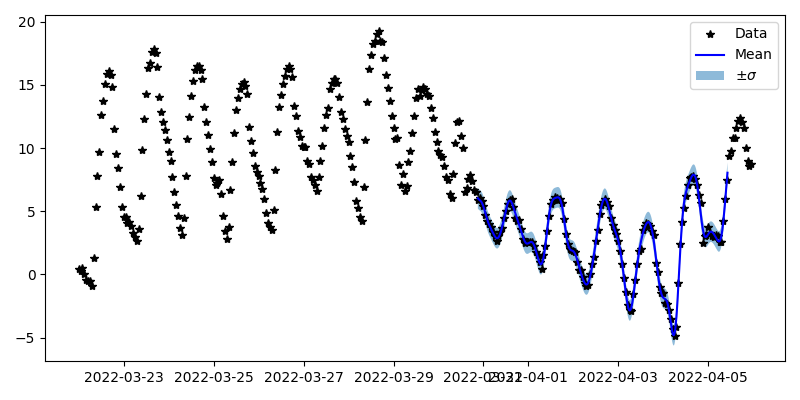

In [ ]:
# Initialize plots
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# for task, ax in enumerate(axes):
# Plot training data as black stars
ax.plot(data_temp_outside.index, temp_outside_tens, 'k*')
# Predictive mean as blue line
ax.plot(data_temp_inside.index, mean.numpy(), 'b')
# Shade in confidence
ax.fill_between(data_temp_inside.index, lower.numpy(), upper.numpy(), alpha=0.5)
# ax.set_ylim([-3, 3])
ax.legend(['Data', 'Mean', '$\pm\sigma$'])
# ax.set_title(f'Task {task + 1}')

fig.tight_layout()

In [ ]:
# Make predictions
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model.predict(time_inside)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

Heat loss coeff. c1 = 0.20461175718339128 kW/°C
Heat loss coeff. c1 = 0.1820262544597106 kW/°C


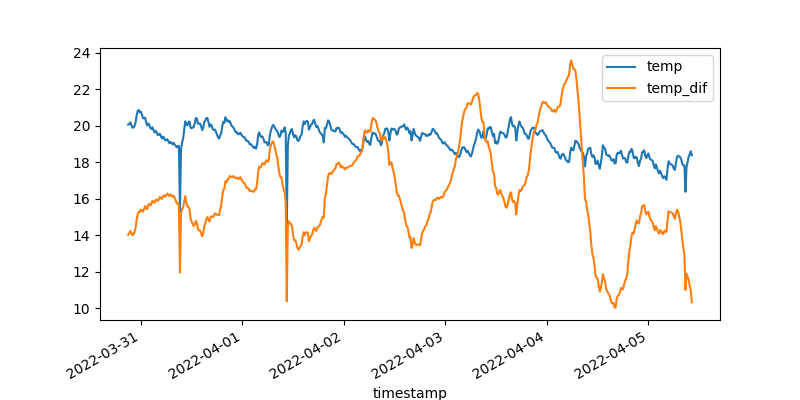

In [ ]:
temp_dif = temp_inside_tens - mean
data_temp_inside['temp_dif'] = temp_dif.numpy()
# fig, ax = plt.subplots(1, 1, figsize=(8, 4))
data_temp_inside.plot( figsize=(8, 4))
total_sum = 0.25 * data_temp_inside['temp_dif'].sum()
range_sum1 = 0.25 * data_temp_inside['temp_dif'][datetime(2022, 3, 30, 19, 5):datetime(2022, 4, 3, 11, 51)].sum()
range_sum2 = 0.25 * data_temp_inside['temp_dif'][datetime(2022, 4, 3, 11, 51):datetime(2022, 4, 4, 11, 26)].sum()
range_sum3 = 0.25 * data_temp_inside['temp_dif'][datetime(2022, 4, 4, 11, 26):datetime(2022, 4, 5, 14, 40)].sum()


a1 = 175464 - 175176 + 7.  # kWh
c1 = a1/range_sum1
a2 = 175542 - 175464 + 2.  # kWh
c2 = a2/range_sum2
a3 = 175633 - 175542 + 2.  # kWh
c3 = a3/range_sum3
print(f'Heat loss coeff. c1 = {c1} kW/°C')
print(f'Heat loss coeff. c2 = {c2} kW/°C')
print(f'Heat loss coeff. c3 = {c3} kW/°C')

In [ ]:
date_dif = ((datetime(2022, 4, 4, 11, 26) - datetime(2022, 3, 30, 19, 5)).total_seconds()/3600.)  # hours
energy_dif_upper = c1 * temp_dif.mean().item() * date_dif
print(f'Energy loss upper bound {energy_dif_upper:.2f} kWh, electricity says {a1+a2:.2f} kWh.')

Energy loss upper bound 376.70 kWh, electricity says 375.00 kWh.


In [ ]:
date_dif = ((datetime(2022, 2, 27, 21, 34) - datetime(2022, 2, 19, 17, 44)).total_seconds()/3600.)  # hours
energy_dif_upper = c1 * 19.52 * date_dif
print(f'Energy loss upper bound {energy_dif_upper:.2f} kWh, electricity says {173022-172331+6:.2f} kWh.')

Energy loss upper bound 782.16 kWh, electricity says 697.00 kWh.


In [ ]:
date_dif = ((datetime(2022, 4, 5, 14, 40) - datetime(2022, 4, 4, 11, 26)).total_seconds()/3600.)  # hours
energy_dif_upper = c1 * 19.52 * date_dif
print(f'Energy loss upper bound {energy_dif_upper:.2f} kWh, electricity says {173022-172331+6:.2f} kWh.')